In [1]:
import os

In [2]:
os.chdir('../..')

In [3]:
import convokit
from convokit import Corpus, download, TriadMotif
import seaborn as sns; sns.set(style="ticks", color_codes=True)
import matplotlib.pyplot as plt
from collections import Counter
import pandas as pd

In [4]:
corpus = Corpus(filename="/Users/calebchiam/Documents/rs-corpus-lastyear")

In [5]:
corpus.print_summary_stats()

Number of Users: 266088
Number of Utterances: 3996437
Number of Conversations: 284028


In [6]:
threads = corpus.utterance_threads(include_root=False)
threads_hypergraphs = dict()
for i, (root, thread) in enumerate(threads.items()):
    G = convokit.HyperConvo._make_hypergraph(uts=thread)
    threads_hypergraphs[root] = G

## Some descriptive stats on the top-level comment threads from 1 Oct 2017 - 1 Oct 2018

In [7]:
# Number of threads
len(threads_hypergraphs)

1678794

## Distribution of number of participants in the threads

In [8]:
from collections import defaultdict
threads_num_users = defaultdict(int)
for thread_id, hg in threads_hypergraphs.items():
    threads_num_users[len(hg.hypernodes)] += 1

In [9]:
sorted(list(threads_num_users.items()))[:30]

[(1, 1215403),
 (2, 263162),
 (3, 87159),
 (4, 38603),
 (5, 20792),
 (6, 12954),
 (7, 8642),
 (8, 6241),
 (9, 4447),
 (10, 3420),
 (11, 2662),
 (12, 2126),
 (13, 1708),
 (14, 1489),
 (15, 1178),
 (16, 1029),
 (17, 872),
 (18, 711),
 (19, 633),
 (20, 525),
 (21, 475),
 (22, 441),
 (23, 370),
 (24, 349),
 (25, 272),
 (26, 260),
 (27, 246),
 (28, 209),
 (29, 194),
 (30, 168)]

In [10]:
def get_earliest_edge_timestamp(edges):
    return min(d['timestamp'] for d in edges)

In [11]:
def identify_ABC(hg, thread_id):
    # A is root, B is first replier to A, C is first third-party replier to A/B
    if thread_id not in hg.utterances: # corpus may be missing some top-level-comments
        return None, None, None, None, None
    
    hypernodes = list(hg.hypernodes.keys())

    A = hg.utterances[thread_id].user
    if len(hypernodes) <= 1: 
        return A, None, None, None, None
    elif len(hypernodes) == 2:
        B = [utt.user for utt in hg.utterances.values() if utt.user != A][0]
        return A, B, None, None, None
    else:
        adj_in_A = hg.adj_in[A]
        users_earliest_edges_to_A = [(user, get_earliest_edge_timestamp(edges)) for user, edges in adj_in_A.items()]
        B = sorted(users_earliest_edges_to_A, key=lambda x: x[1])[0][0]
        
        users_earliest_edges_to_B = [(user, get_earliest_edge_timestamp(edges)) for user, edges in hg.adj_in[B].items()]
        
        A_B = {A, B}
        
        C_pos1 = [(user, ts) for (user, ts) in users_earliest_edges_to_A if user != B]
        C_pos2 = [(user, ts) for (user, ts) in sorted(users_earliest_edges_to_B, key=lambda x:x[1]) if user != A]

        if len(C_pos1) == 0:
            C, C_timestamp = C_pos2[0]
            C_responds_to = 'B'
        elif len(C_pos2) == 0:
            C, C_timestamp = C_pos1[0]
            C_responds_to = 'A'
        else:
            # both lists are non-empty
            if C_pos1[0][1] < C_pos2[0][1]: # compare timestamps
                C, C_timestamp = C_pos1[0]
                C_responds_to = 'A'
            else:
                C, C_timestamp = C_pos2[0]
                C_responds_to = 'B'
        
        return A, B, C, C_timestamp, C_responds_to


In [12]:
identify_ABC(threads_hypergraphs['e58r4yf'], 'e58r4yf')

(User([('name', 'CinematicHeart')]),
 User([('name', 'Howdidthishappen62')]),
 User([('name', 'squashedgTA')]),
 1535850243,
 'A')

In [13]:
convokit.display_thread(threads, 'e58r4yf')

CinematicHeart
    Howdidthishappen62
    squashedgTA
        CinematicHeart
        Polominty


In [14]:
def get_reciprocal_density_and_last_speaker(hg, userA, userB, before_ts = 9999999999):
    B_to_A = [edge for edge in hg.adj_in[userA].get(userB, []) if edge['timestamp'] <= before_ts]
    A_to_B = [edge for edge in hg.adj_in[userB].get(userA, []) if edge['timestamp'] <= before_ts]
    last_speaker_before_C = sorted(A_to_B + B_to_A, key=lambda edge: edge['timestamp'])[-1]['speaker']
    last_speaker = None
    if last_speaker_before_C == userA:
        last_speaker = 'A'
    elif last_speaker_before_C == userB:
        last_speaker = 'B'
    else:
        raise ValueError("Invalid speaker")
    return len(B_to_A + A_to_B), last_speaker

In [15]:
from itertools import permutations
def identify_final_motif(hg, userA, userB, userC):
    # We use the identities of user A, B, C (i.e. top-level-commenter, first replier, first third-party replier)
    # to simplify the typically-difficult final motif identification step
    num_edge_dirs = 0
    for user_pair in permutations([userA, userB, userC], 2):
        if len(hg.adj_in[user_pair[0]].get(user_pair[1], [])) > 0:
            num_edge_dirs += 1
    
    # sanity check
    assert 2 <= num_edge_dirs <= 6
    if num_edge_dirs == 6:
        return 'TRIRECIPROCAL_TRIADS'
    elif num_edge_dirs == 5:
        return 'DIRECIPROCAL_2TO3_TRIADS'
    elif num_edge_dirs == 4:
        if len(hg.adj_out[userB].get(userC, [])) == 0 and len(hg.adj_out[userC].get(userB, [])) == 0:
            # B and C do not talk
            return "DIRECIPROCAL_TRIADS"
        elif len(hg.adj_out[userB].get(userC, [])) > 0 and len(hg.adj_out[userC].get(userB, [])) > 0:
            # B and C talk to each other
            return "INCOMING_RECIPROCAL_TRIADS"
        elif len(hg.adj_out[userC].get(userB, [])) > 0 and len(hg.adj_out[userC].get(userA, [])) > 0 and \
                len(hg.adj_in[userC].get(userB, [])) == 0 and len(hg.adj_in[userC].get(userA, [])) == 0:
            # C talks to A and B but gets no responses
            return "OUTGOING_RECIPROCAL_TRIADS"
        elif len(hg.adj_out[userB].get(userC, [])) > 0 and len(hg.adj_out[userB].get(userA, [])) > 0 and \
                len(hg.adj_in[userB].get(userC, [])) == 0 and len(hg.adj_in[userC].get(userA, [])) == 0:
            # B talks to A and C but gets no response
            return "OUTGOING_RECIPROCAL_TRIADS"
        else:
            return "DIRECTED_CYCLE_1TO3_TRIADS"
    elif num_edge_dirs == 3:
        if len(hg.adj_in[userC].get(userA, [])) > 0: # A talks to C
            if len(hg.adj_in[userA].get(userC, [])) > 0: # C talks to A
                return "INCOMING_1TO3_TRIADS"
            else: # C does not talk to A
                return "DIRECTED_CYCLE_TRIADS"
        else: # A does not tak to C
            if len(hg.adj_out[userC].get(userB, [])) > 0: # C talks to B
                return "OUTGOING_3TO1_TRIADS"
            else:
                return "INCOMING_2TO3_TRIADS"
    elif num_edge_dirs == 2:
        # cannot be outgoing by definition, can only be incoming or unidirectional
        if len(hg.adj_in[userA].get(userC, [])) > 0:
            return 'INCOMING_TRIADS'
        else:
            return 'UNIDIRECTIONAL_TRIADS'

        

In [16]:
missing_tlc_threads = []
one_commenter_threads = []
two_commenter_threads = []
three_or_more_threads = []
for thread_id, hypergraph in threads_hypergraphs.items():
    userA, userB, userC, C_timestamp, C_responds_to = identify_ABC(hypergraph, thread_id)
    if userA is None:
        missing_tlc_threads.append(thread_id)
    elif userB is None:
        one_commenter_threads.append(thread_id)
    elif userC is None:
        density, last_speaker = get_reciprocal_density_and_last_speaker(hypergraph, userA, userB)
        two_commenter_threads.append((thread_id, 'DYADIC_TRIADS', density, "nil", last_speaker))
    else:
        final_type = identify_final_motif(hypergraph, userA, userB, userC)
        density_before_C, last_speaker = get_reciprocal_density_and_last_speaker(hypergraph, userA, 
                                                                                 userB, before_ts=C_timestamp)
        three_or_more_threads.append((thread_id, final_type, density_before_C, C_responds_to, last_speaker))

In [17]:
print("Total threads", len(threads))
print("threads with missing top level comment", len(missing_tlc_threads))
print("threads with one commenter", len(one_commenter_threads))
print("threads with two commenters", len(two_commenter_threads))
print("threads with >=3 commenters", len(three_or_more_threads))


Total threads 1678794
threads with missing top level comment 713
threads with one commenter 1214936
threads with two commenters 263008
threads with >=3 commenters 200137


In [18]:
df = pd.DataFrame(data=two_commenter_threads+three_or_more_threads, columns=['thread_id', 'motif_type', 'density', 'responds_to', 'last_speaker'])

In [19]:
df = df.set_index('thread_id')

In [20]:
df.head()

,motif_type,density,responds_to,last_speaker
thread_id,,,,
dnqikm1,DYADIC_TRIADS,4,nil,A
dnqikto,DYADIC_TRIADS,1,nil,B
dnqikx5,DYADIC_TRIADS,2,nil,A
dnqil9m,DYADIC_TRIADS,1,nil,B
dnqilab,DYADIC_TRIADS,1,nil,B


In [21]:
Counter(df['motif_type'])

Counter({'DYADIC_TRIADS': 263008,
         'INCOMING_TRIADS': 35381,
         'OUTGOING_RECIPROCAL_TRIADS': 3472,
         'INCOMING_RECIPROCAL_TRIADS': 17905,
         'UNIDIRECTIONAL_TRIADS': 52069,
         'INCOMING_2TO3_TRIADS': 15133,
         'OUTGOING_3TO1_TRIADS': 53901,
         'DIRECIPROCAL_TRIADS': 6600,
         'INCOMING_1TO3_TRIADS': 6382,
         'DIRECTED_CYCLE_1TO3_TRIADS': 2215,
         'TRIRECIPROCAL_TRIADS': 3501,
         'DIRECTED_CYCLE_TRIADS': 912,
         'DIRECIPROCAL_2TO3_TRIADS': 2666})

In [22]:
sorted(list(Counter(df['density']).items()))[:30]

[(1, 317244),
 (2, 88398),
 (3, 30840),
 (4, 13293),
 (5, 6277),
 (6, 3059),
 (7, 1656),
 (8, 903),
 (9, 510),
 (10, 320),
 (11, 171),
 (12, 135),
 (13, 69),
 (14, 55),
 (15, 39),
 (16, 36),
 (17, 23),
 (18, 21),
 (19, 3),
 (20, 12),
 (21, 7),
 (22, 10),
 (23, 1),
 (24, 5),
 (25, 1),
 (26, 3),
 (27, 1),
 (28, 6),
 (29, 2),
 (30, 2)]

In [23]:
Counter(df['responds_to'])

Counter({'nil': 263008, 'A': 69761, 'B': 130376})

## Distribution of responds_to for each density for each motif

In [24]:
triad_order = convokit.TriadMotif.get_motif_types()

In [25]:
density_threshold = 12

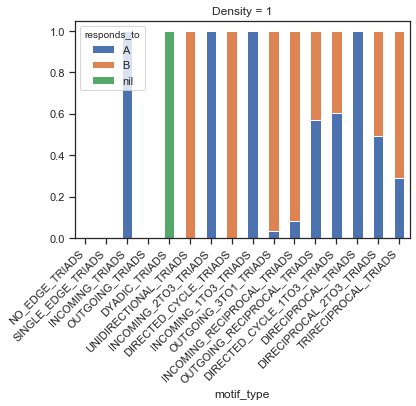

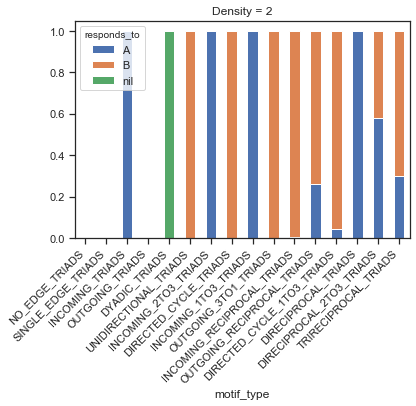

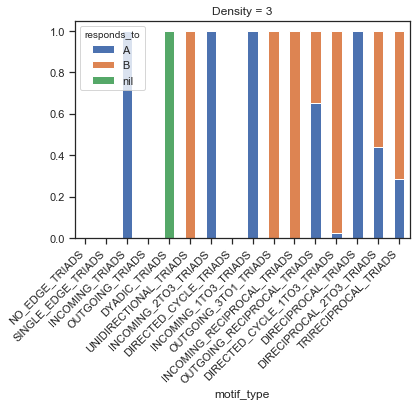

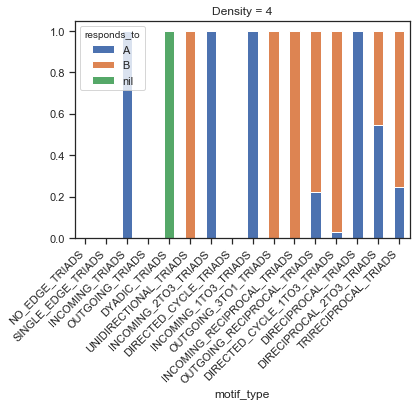

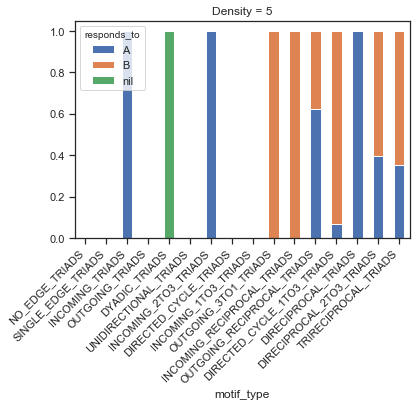

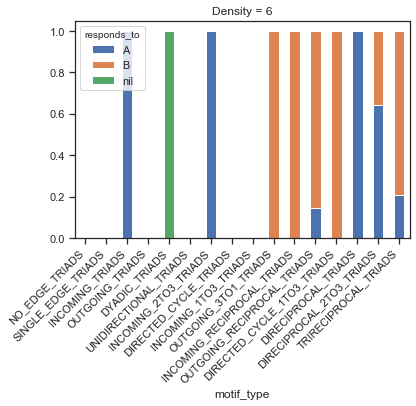

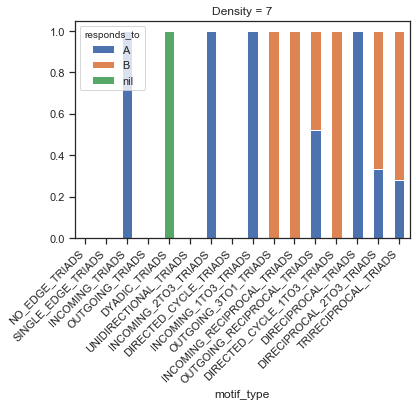

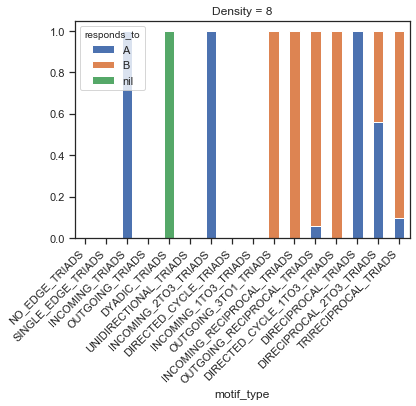

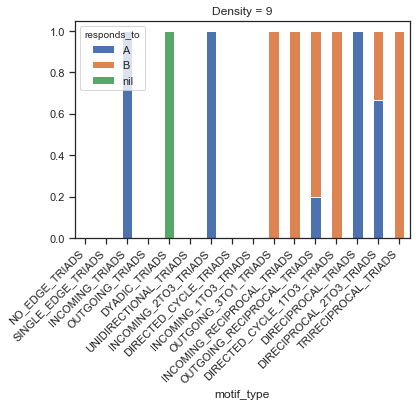

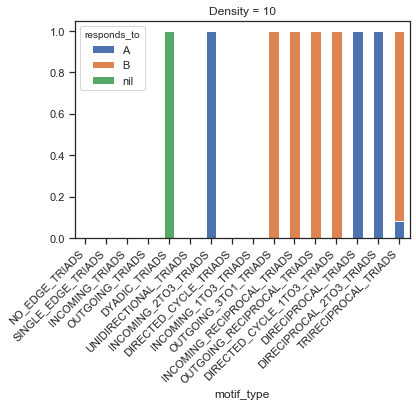

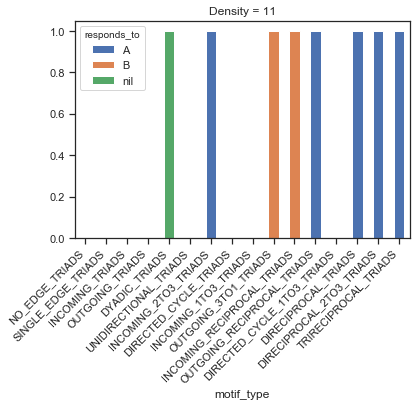

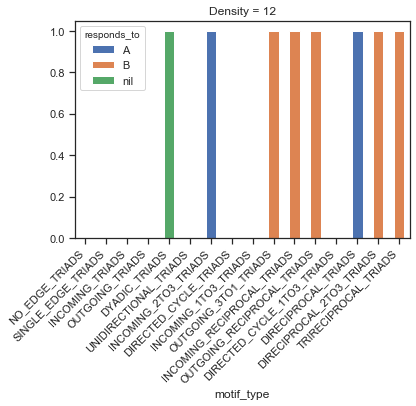

In [26]:
for i in sorted(Counter(df['density']).keys()):
    if i > density_threshold: continue
    props = df[df['density']==i].groupby("motif_type")['responds_to'].value_counts(normalize=True).unstack()
    props.reindex(triad_order).plot(kind='bar', stacked='True')
    plt.title("Density = {}".format(i))
    plt.xticks(rotation=45, horizontalalignment='right')


By definition, some of these triads will always have C respond to either A or B only. To make it more interesting and interpretable, we focus on those that can be either A or B.

In [27]:
triad_order = ['OUTGOING_RECIPROCAL_TRIADS', 'DIRECTED_CYCLE_1TO3_TRIADS',
              'DIRECIPROCAL_2TO3_TRIADS', 'TRIRECIPROCAL_TRIADS']

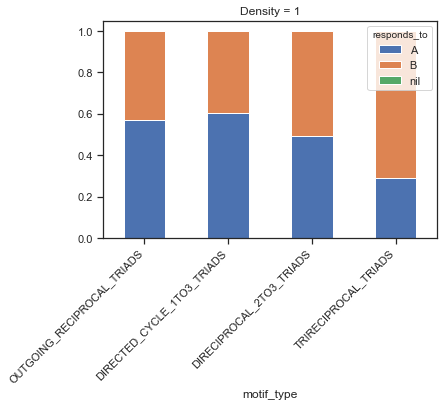

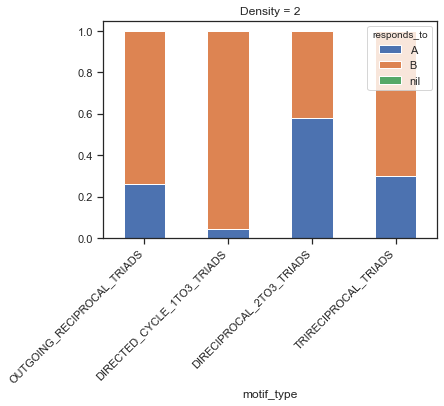

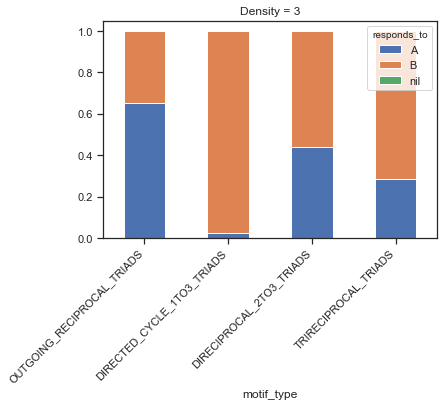

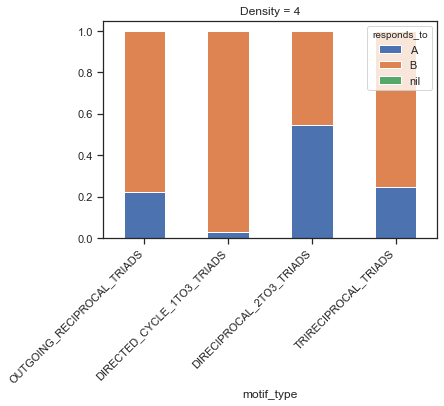

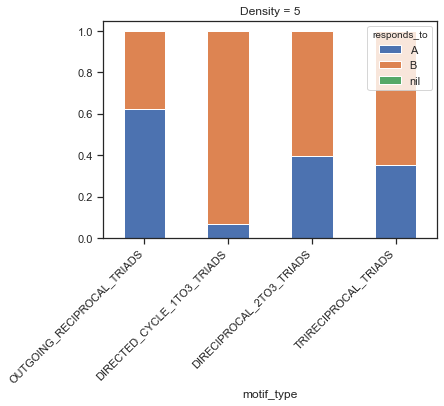

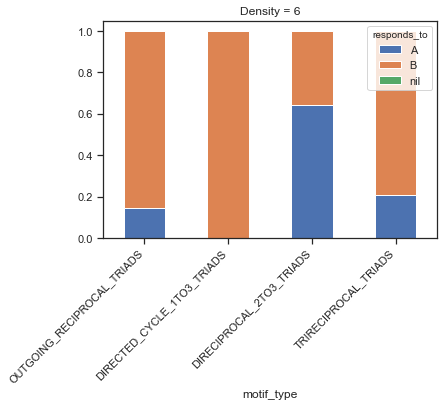

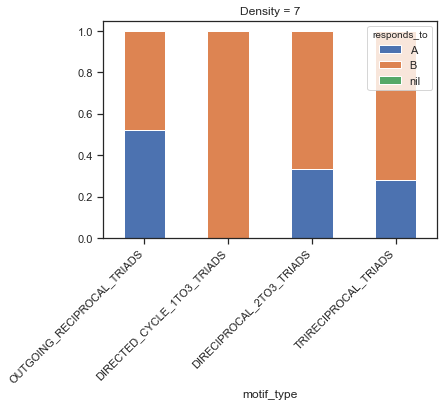

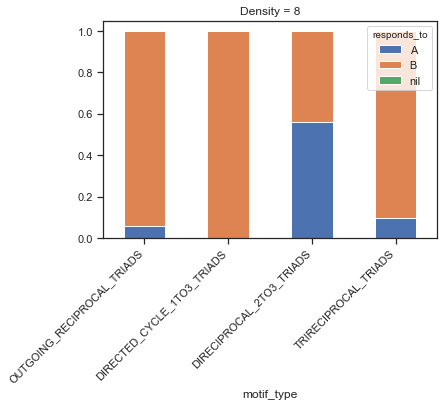

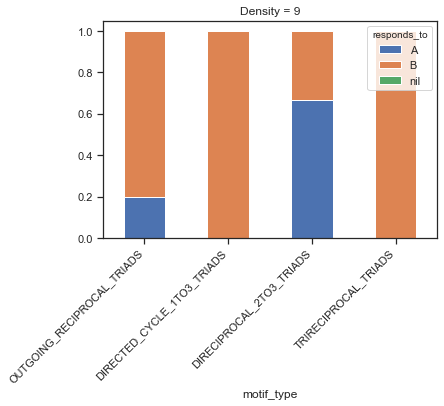

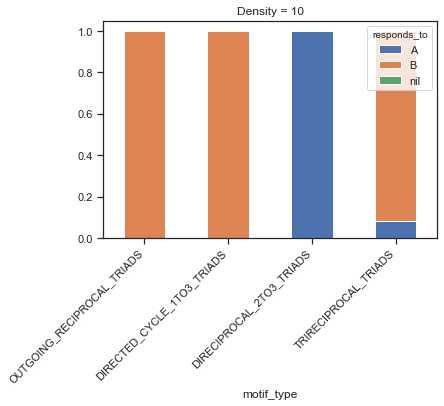

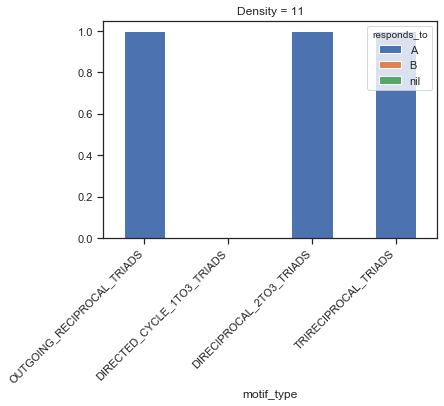

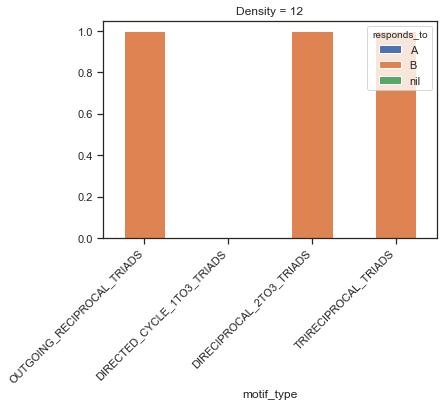

In [28]:
for i in sorted(Counter(df['density']).keys()):
    if i > density_threshold: continue
    props = df[df['density']==i].groupby("motif_type")['responds_to'].value_counts(normalize=True).unstack()
    props.reindex(triad_order).plot(kind='bar', stacked='True')
    plt.title("Density = {}".format(i))
    plt.xticks(rotation=45, horizontalalignment='right')

## Overall response-to distribution for each density (ignoring motif type)

In [29]:
grouped_by_density = df.groupby('density')['responds_to'].value_counts(normalize=True).unstack()

In [30]:
grouped_by_density.index

Int64Index([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
             14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
             27,  28,  29,  30,  32,  34,  36,  38,  40,  42,  44,  48,  50,
             53,  56,  62,  64,  66,  68,  70,  72,  77,  80,  86, 204],
           dtype='int64', name='density')

In [31]:
grouped_by_density[grouped_by_density.index <= density_threshold]

responds_to,A,B,nil
density,,,
1,0.155748,0.285578,0.558674
2,0.162594,0.254485,0.582920
3,0.095525,0.305642,0.598833
4,0.133228,0.287971,0.578801
5,0.092560,0.298391,0.609049
6,0.117032,0.274273,0.608696
7,0.070048,0.314614,0.615338
8,0.105205,0.303433,0.591362
9,0.070588,0.274510,0.654902


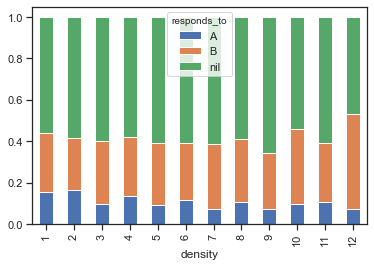

In [32]:
grouped_by_density[grouped_by_density.index <= density_threshold].plot(kind='bar', stacked=True)

## Distribution of last speaker before C for each density for each motif

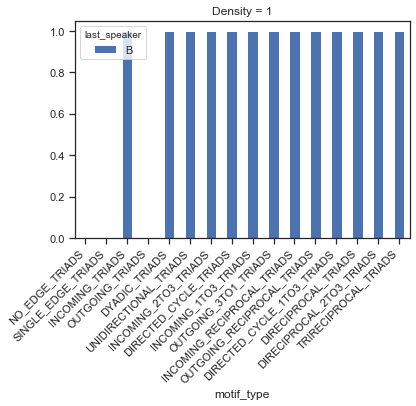

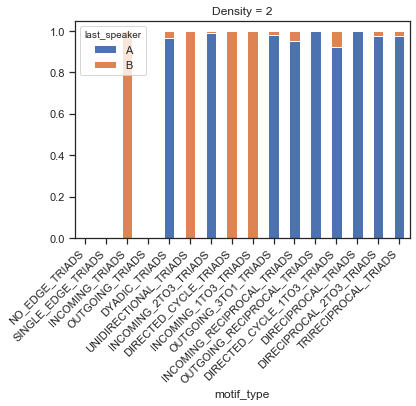

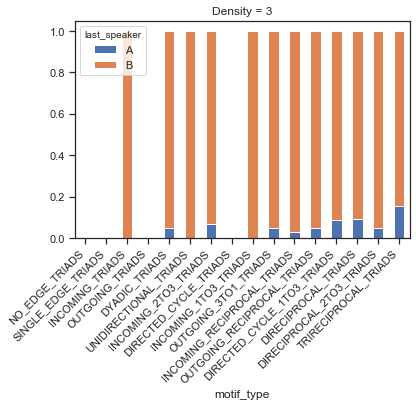

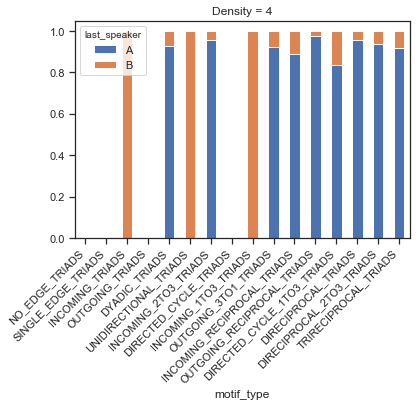

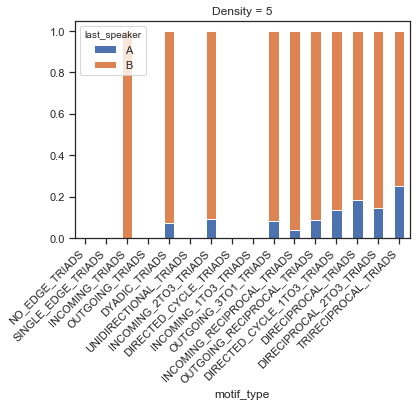

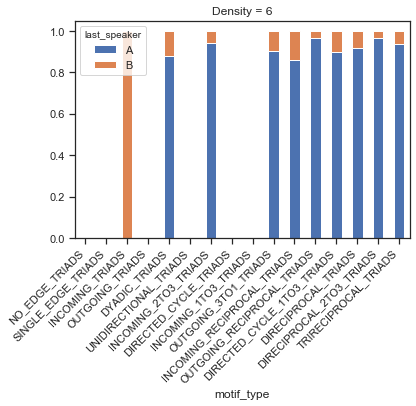

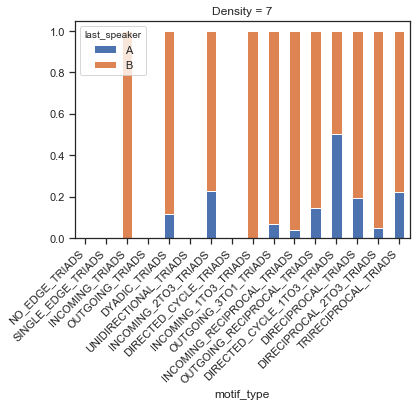

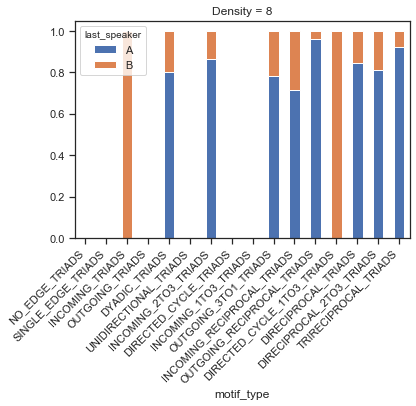

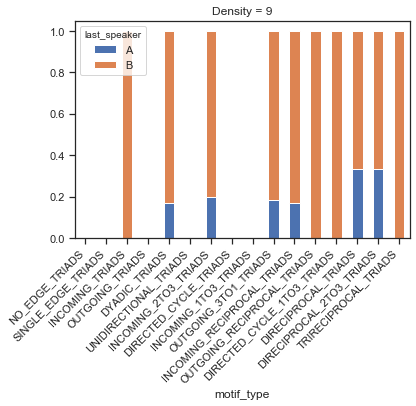

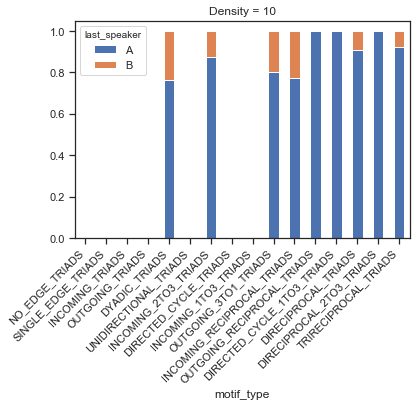

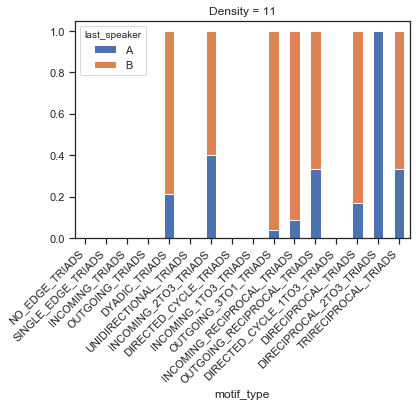

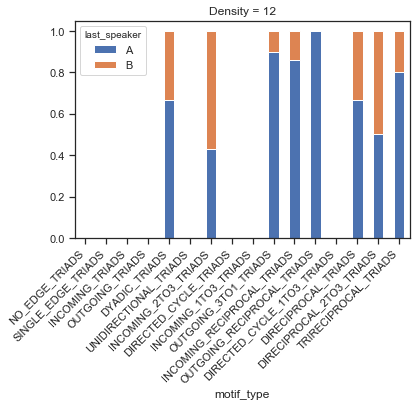

In [33]:
for i in sorted(Counter(df['density']).keys()):
    if i > density_threshold: continue
    props = df[df['density']==i].groupby("motif_type")['last_speaker'].value_counts(normalize=True).unstack()
    props.reindex(convokit.TriadMotif.get_motif_types()).plot(kind='bar', stacked='True')
    plt.title("Density = {}".format(i))
    plt.xticks(rotation=45, horizontalalignment='right')

## Last speaker before C distribution for each density (ignoring motif type, exclude dyadic)

In [34]:
last_speaker_grouped_by_density = df[df['motif_type'] != 'DYADIC_TRIADS'].groupby('density')['last_speaker'].value_counts(normalize=True).unstack()

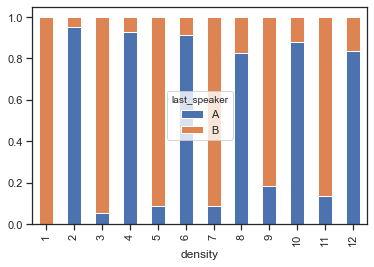

In [35]:
last_speaker_grouped_by_density[last_speaker_grouped_by_density.index <= density_threshold].plot(kind='bar', stacked=True)

## Last speaker before C distribution for each motif for each density

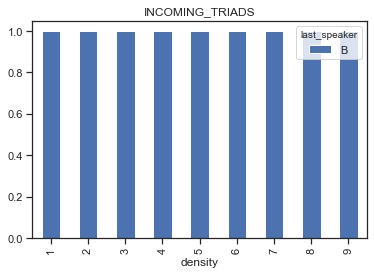

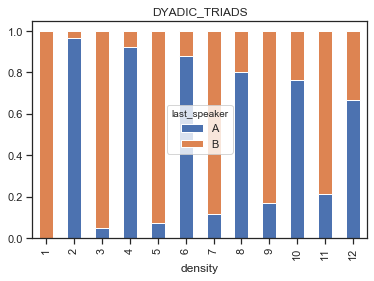

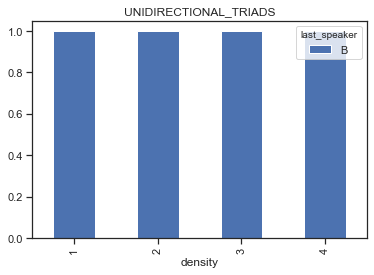

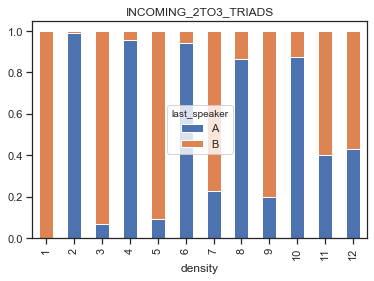

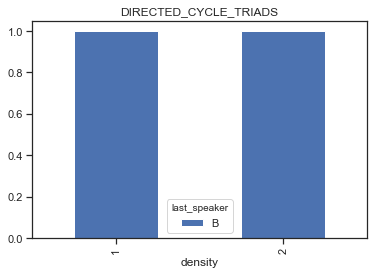

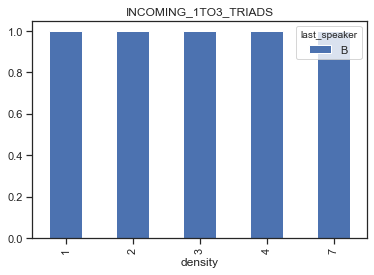

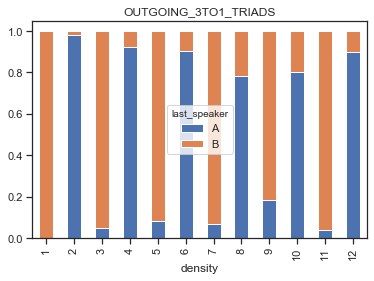

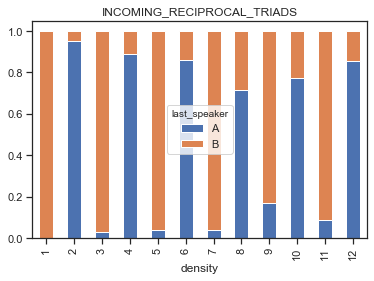

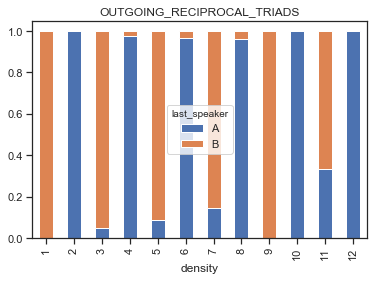

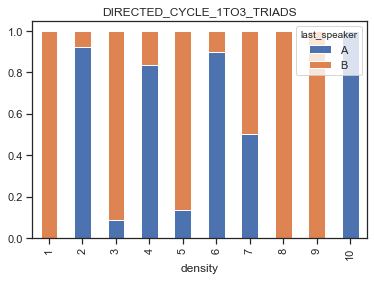

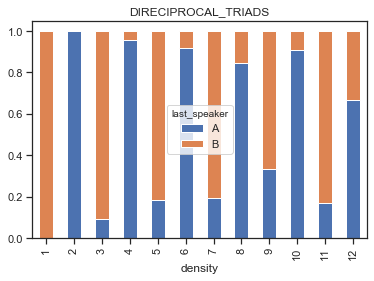

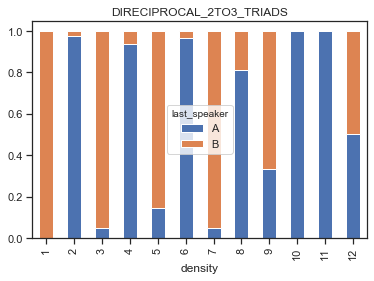

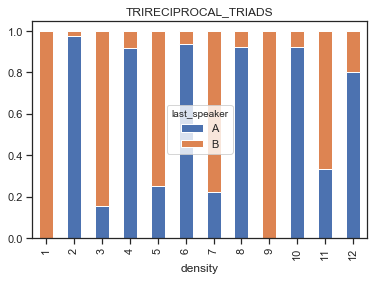

In [57]:
for motif_type in convokit.TriadMotif.get_motif_types():
    if motif_type in ['NO_EDGE_TRIADS', 'SINGLE_EDGE_TRIADS', 'OUTGOING_TRIADS']: continue
    last_speaker_grouped_by_density = df[df['motif_type'] == motif_type].groupby('density')['last_speaker'].value_counts(normalize=True).unstack()
    last_speaker_grouped_by_density[last_speaker_grouped_by_density.index <= density_threshold].plot(kind='bar', stacked=True).set_title(motif_type)

## Last speaker before C distribution for each density (dyadic only)

In [36]:
# This should give something obvious -- we include it only as a sanity check
last_speaker_grouped_by_density = df[df['motif_type'] == 'DYADIC_TRIADS'].groupby('density')['last_speaker'].value_counts(normalize=True).unstack()

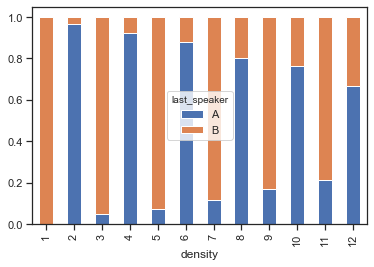

In [37]:
last_speaker_grouped_by_density[last_speaker_grouped_by_density.index <= density_threshold].plot(kind='bar', stacked=True)

## For each final type, what is the distribution of responses to A / B for each density?

In [38]:
dfs_normalized_grouped = [df[df['density']==i].groupby("motif_type")['responds_to'].value_counts(normalize=True).unstack() for i in Counter(df['density']).keys() if i <= density_threshold]

In [39]:
len(dfs_normalized_grouped)

12

In [40]:
for idx, sub_df in enumerate(dfs_normalized_grouped):
    sub_df['density'] = idx + 2

In [41]:
df_all_normalized = pd.concat(dfs_normalized_grouped, sort=False)

In [42]:
df_all_normalized.head().index

Index(['DIRECIPROCAL_2TO3_TRIADS', 'DIRECIPROCAL_TRIADS',
       'DIRECTED_CYCLE_1TO3_TRIADS', 'DYADIC_TRIADS', 'INCOMING_1TO3_TRIADS'],
      dtype='object', name='motif_type')

In [43]:
final_types = list(set(df_all_normalized.index))

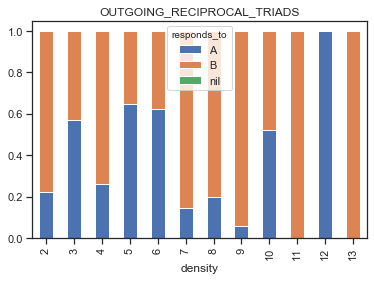

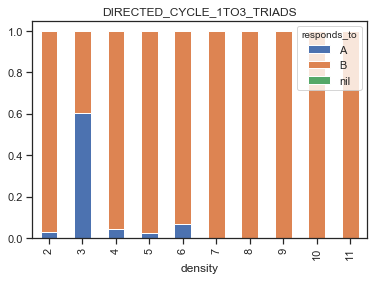

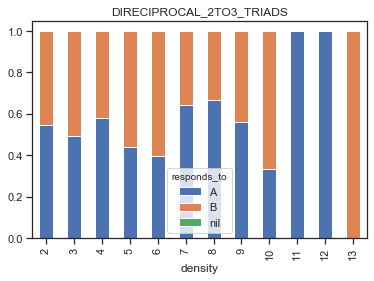

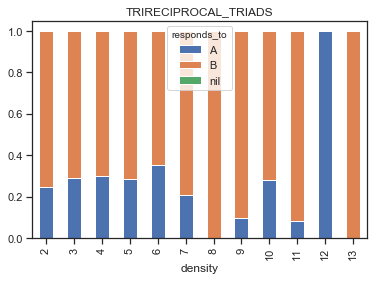

In [44]:
for final_t in triad_order:
    d = df_all_normalized[df_all_normalized.index == final_t]
    d.index = d['density']
    del d['density']
    d.plot(kind="bar", stacked=True).set_title(final_t)

## Confusion matrices for responds_to and last_speaker across densities

In [45]:
df.head()

,motif_type,density,responds_to,last_speaker
thread_id,,,,
dnqikm1,DYADIC_TRIADS,4,nil,A
dnqikto,DYADIC_TRIADS,1,nil,B
dnqikx5,DYADIC_TRIADS,2,nil,A
dnqil9m,DYADIC_TRIADS,1,nil,B
dnqilab,DYADIC_TRIADS,1,nil,B


In [46]:
hm_df = df[(df['motif_type'] != 'DYADIC_TRIADS') & (df['density']==2)].groupby("last_speaker")['responds_to'].value_counts().unstack()

In [47]:
print(hm_df)

responds_to       A      B
last_speaker              
A             13549  21522
B               824    974


In [48]:
hm_df /= sum(sum(hm_df.values))

In [49]:
hm_df

responds_to,A,B
last_speaker,,
A,0.367490,0.583742
B,0.022349,0.026418


In [50]:
hm_dfs_total_count = []
hm_dfs_last_speaker = []
for i in sorted(Counter(df['density']).keys()):
    if i > density_threshold: continue
    hm_df = df[(df['density']==i) & (df['motif_type'] != 'DYADIC_TRIADS')].groupby("last_speaker")['responds_to'].value_counts(normalize=True).unstack()
#     hm_df /= sum(sum(hm_df.values))
    print("\n##########\n")
    print("Density", i)
    print()
    print("Normalized with respect to last_speaker:")
    print(hm_df)
    hm_dfs_last_speaker.append(hm_df)
    print()
    
    print("Normalized with respect to total count:")
    hm_df = df[(df['density']==i) & (df['motif_type'] != 'DYADIC_TRIADS')].groupby("last_speaker")['responds_to'].value_counts().unstack()
    hm_df /= sum(sum(hm_df.values))
    hm_dfs_total_count.append(hm_df)
    print(hm_df)
    print()


##########

Density 1

Normalized with respect to last_speaker:
responds_to          A         B
last_speaker                    
B             0.352908  0.647092

Normalized with respect to total count:
responds_to          A         B
last_speaker                    
B             0.352908  0.647092


##########

Density 2

Normalized with respect to last_speaker:
responds_to          A         B
last_speaker                    
A             0.386331  0.613669
B             0.458287  0.541713

Normalized with respect to total count:
responds_to          A         B
last_speaker                    
A             0.367490  0.583742
B             0.022349  0.026418


##########

Density 3

Normalized with respect to last_speaker:
responds_to          A         B
last_speaker                    
A             0.353968  0.646032
B             0.231903  0.768097

Normalized with respect to total count:
responds_to          A         B
last_speaker                    
A             0.0180

## Heatmaps based on total count distribution

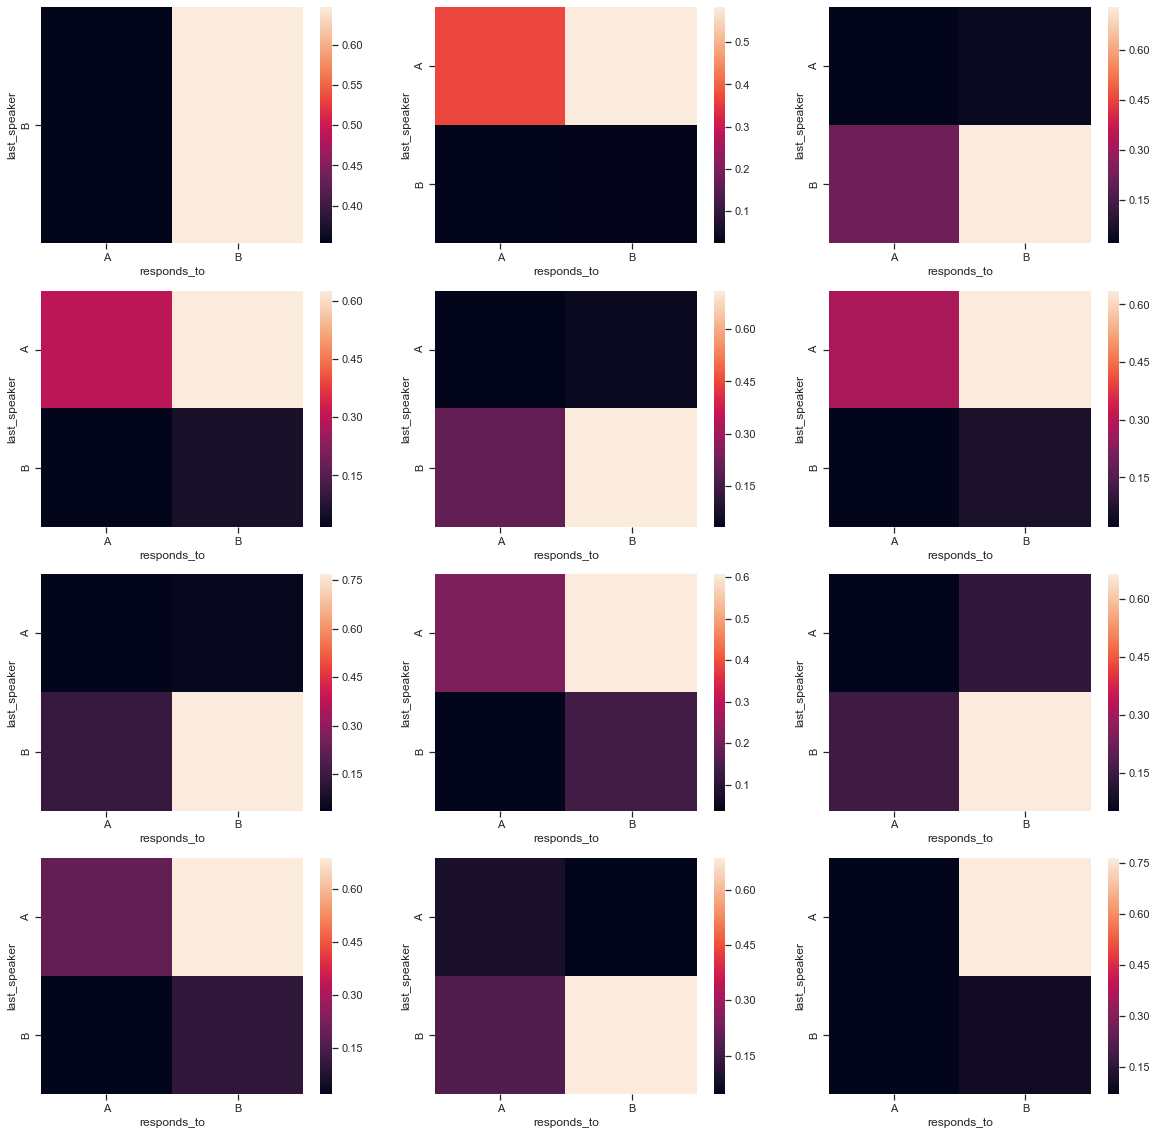

In [51]:
fig = plt.figure(figsize=(20, 20))
axes = [fig.add_subplot(*idx) for idx in [(4, 3, pos) for pos in range(1, 13)]]
for idx, hm_df in enumerate(hm_dfs_total_count):
    sns.heatmap(data=hm_df, ax=axes[idx])

## Heatmaps normalized to last_speaker

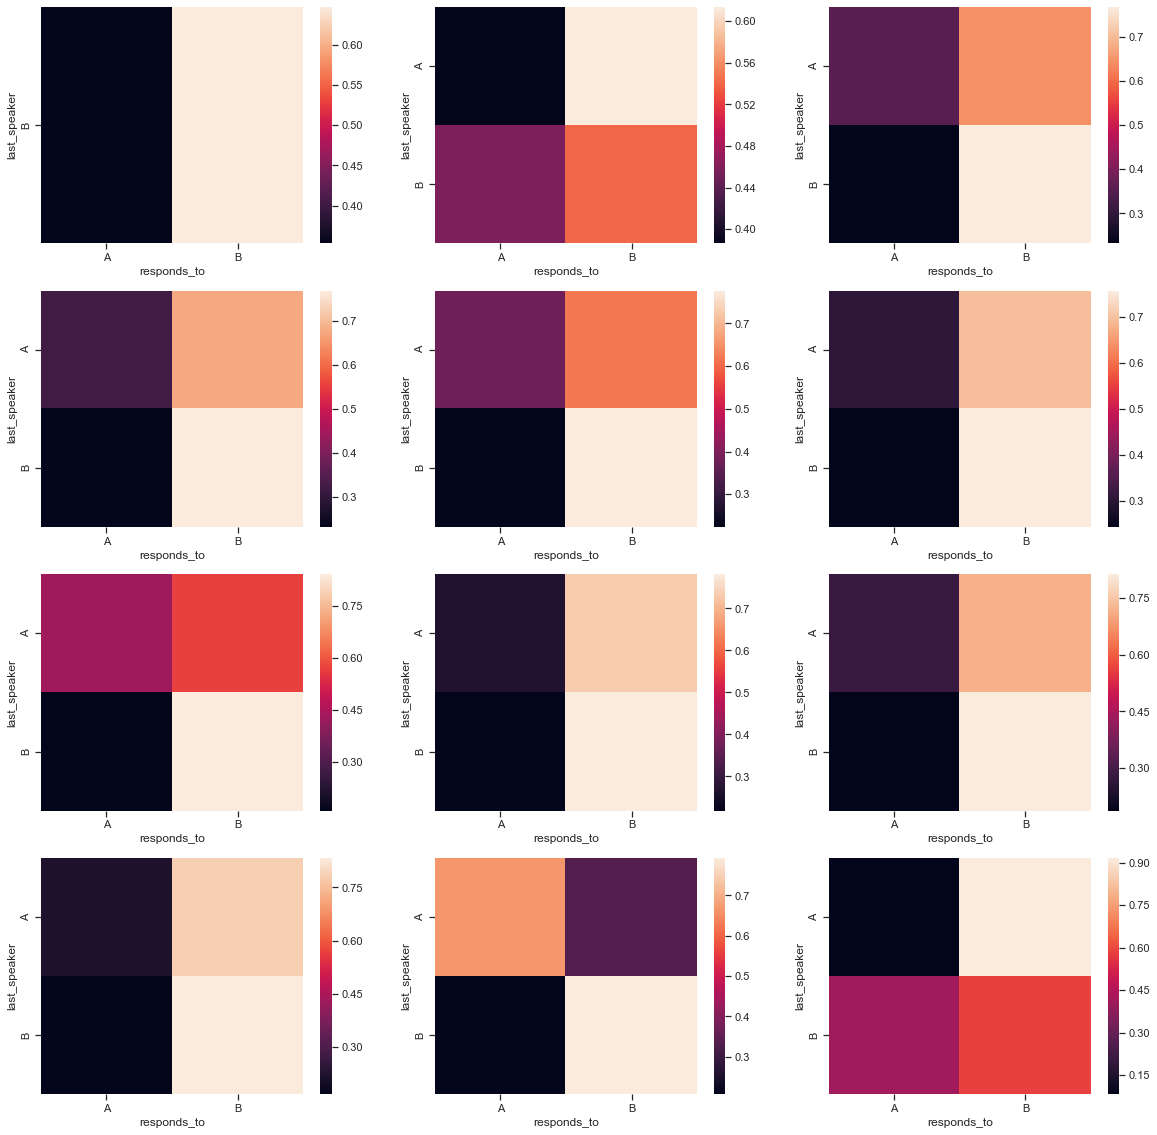

In [52]:
fig = plt.figure(figsize=(20, 20))
axes = [fig.add_subplot(*idx) for idx in [(4, 3, pos) for pos in range(1, 13)]]
for idx, hm_df in enumerate(hm_dfs_last_speaker):
    sns.heatmap(data=hm_df, ax=axes[idx])